In [5]:
import pickle # für Obj serialisation
#import numpy as np
#import matplotlib
import os
import time
from datetime import datetime
import json
#import csv
from pathlib import Path
import csv
from typing import List
import numpy
import numpy as np
import matplotlib.pyplot as plt

In [6]:
TransitionPeriod = 4
amazon_ips = {} # Amazon meint wohl ob eingehend oder ausgehend
GAMMA = 0.25
observation_lengths = [180, 300, 600, 900, 1800, 3600, 4000 ,5000] # in seconds (3min - 30min)
LENGTH = 3600 #
"""Eq 3600"""
MAGIC_IsUserPacketARelevantBurstPacket = 40 #Wird bei der Event Extraction verwendet... Wenn größer, dann wird Paket als Relevantes Burst Paket verwendet.
DELTA = 15 # seconds -> Maximale Zeitliche Differenz.. Wird schrittweise erhöht 
#size_threshold = 10000


In [7]:
def convert_time(timestamps, start_time):
    """
    Converts timestamps to relative timestamps (relative to Startime)
    """
    converted_timestamps = []
    for t in timestamps:
        converted = t - start_time
        if converted < 0:
            print('Error: timestamp is larger than start time with t = {} and start_time = {}'.format(t, start_time))
        converted_timestamps.append(converted)
    return converted_timestamps    

def get_on_periods_of_sender_2(timestamps, message_sizes):
    """
    Returns an Array of timestamp and messagesSizes Tupels\\
    eg.   
     `[(timestamps[0], messagesizes[0]), (timestamps[1], messagesizes[1]).... ]`
    """
    global TransitionPeriod 
    bursts = []
    timestamps_Sizes_tupel = zip(timestamps, message_sizes) # Creates a Tupel... (timestamps[0], messagesizes[0])...
    for t, s in timestamps_Sizes_tupel:
        bursts.append((t, s))
    return bursts


def get_bursts_user(timestamps, user_packet_sizes):
    """
    Returnes A List of Tupels containing the Timestamps and the Packet Burstsizes (Filters only Correct burst (40bytes threshold))
    Merges Packets together that belong to one Burst (one Second ?) some Magic constant -> Should be the T_e Parameter
    """
    global TransitionPeriod
    is_in_burst = False
    bursts = []
    burst_size = 0
    last_burst_index = 0
    MTU = 1500 #TODO Constant ist damit wirklich die MTU gemeint ? ... Oder wird damit nur nochmal doppelt geprüft falls leitung mit geringer bandbreite verwendet wird.. Aber dann macht MTU size keinen sinn..

    for time_iter in range(0, len(timestamps)): # Time_iter ist index für jede Nachricht (markiert durch timestamp)
        if time_iter == len(timestamps) - 1 and is_in_burst: # Wenn letzte Msg und wir innerhalb eines Bursts sind ?
            if burst_size > MTU: # Und es ein Burst Paket ist -> Verstehe den MTU parameter nicht so richtig -> Seite 8 unten rechts
                bursts.append((timestamps[last_burst_index], burst_size)) # Speichern wir diesen Burst, so wie auch normal (Nur das hier richtigerweise der LastburstIndex richtig ist)!!!
                break

        if (timestamps[time_iter] - timestamps[last_burst_index]) > 1: # Wenn mehr als eine Sekunde vergangen ist seit ende des letzten Burst -> Sind wir nicht mehr in einem Burst
            if is_in_burst:
                if burst_size > MTU:
                    #TODO is Programmier Fehler hier ? müsste nicht last_burst_index sein? Siehe seite 9 und 6 Zeilen weiter oben
                    bursts.append((timestamps[time_iter], burst_size)) # Speichern des Bursts (als Tupel Timestamp mit der Burstgröße) (Warum nicht den Letzten Burst Timestamp???!!)
                is_in_burst = False #-> Sind wir nicht mehr in einem Burst
                burst_size = 0
        if user_packet_sizes[time_iter] > MAGIC_IsUserPacketARelevantBurstPacket: # magic constant -> Wenn packet size > 40 Bytes (Wahrscheinlich wenn nicht nur steuerungsinformationen) #TODO
            if is_in_burst == False:
                is_in_burst = True # Befinden wir uns in einem Burst
            last_burst_index = time_iter # Setzen des des Bursts (wird immer neu gesetzt -> Markiert das Ende)
            burst_size += user_packet_sizes[time_iter] # Addieren des Bursts
    return bursts

def find_intervals(period_points, minute):
    """
    Splits the Period Points list into Time Intervals. Specified by "minute"
    
    `return:` list of periodPoints (wahrscheinlich msgEvents). Jedes Listenelement ist eine Liste mit msgEvents innerhalb eines Intervals
    """
    global LENGTH #=3600
    num_of_intervals = int(LENGTH / minute)
    intervals = []
    for i in range(num_of_intervals):
        intervals.append([]) # the Empty element
        startpoint = i * minute
        endpoint = (i + 1) * minute
        for j in range(len(period_points)):
            if startpoint <= period_points[j][0] and period_points[j][0] < endpoint:
                intervals[-1].append(period_points[j])
    return intervals

def find_intervals_channel(period_points, minute, message_types):
    """
    same as find_intervals. Except that it filters out text type Messages.. 
    copy and Paste Code
    """
    global LENGTH #=3600 = Eine stunde! 
    num_of_intervals = int(LENGTH / minute) # Wieviele Intervalle innerhalb einer Stunde. Weil die Period Points pro Stunde sind.. 
    intervals = []
    for i in range(num_of_intervals):
        intervals.append([])
        startpoint = i * minute
        endpoint = (i + 1) * minute
        for j in range(len(period_points)):
            if startpoint <= period_points[j][0] and period_points[j][0] < endpoint and message_types[j] != 'text':
                intervals[-1].append(period_points[j])
    return intervals


def find_matches(channel_interval, user_interval):
    """    

    Vergleicht channel Intervals mit den Userintervals, zählt alle Matches der Events (time und size)
    Ein Match ist wenn die time (max) +- DELTA sekunden auseinanderliegt, und die Größen abweichung kleiner ist als GAMMA*Size (Also die relative größe des Bursts)

    `Return:` Die Treffer Quote (number_of_matches / all Events)
    """
    number_of_matches = 0
    number_of_nonmatches = 0
    matched_user_intervals = set()
    # Vergleicht jedes Event aus channel_interval mit jedem user_intervall (Versucht diese zu machten. Mit Gamma (Size Threshold) und Delta (Time Threshold))
    # Probiert verschiedene Deltas durch (Zeitliche Abweichungen)
    # Wenn ein Match gefunden wurde, dann wird mit dem nächsten channel_interval fortgeführt
    for j in range(min(len(channel_interval), len(user_interval))):
        time = channel_interval[j][0]
        size = channel_interval[j][1]
        is_matched = False
        for d in range(1, DELTA): # Innerhalb von 1-15 sekunden -> Geht verschiedene Delta werte durch. Zeitliche Differenz. Um uhrzeit drifft auszugleichen
            for i in range(len(user_interval)):
                if user_interval[i] in matched_user_intervals: # Wenn  schon gematcht -> Weitergehen
                    continue
                if abs(user_interval[i][0] - time) < d: # Wenn innerhalb des Deltas (welches schrittweise erhöt wird) Also Differenz der beiden Timestamps
                    if abs(size - user_interval[i][1]) < GAMMA * size: # Hmm hier wird gamma in Abhändigkei der Größe gesetzt. Relative Abweichung... (Im Paper anders )
                        matched_user_intervals.add(user_interval[i])
                        number_of_matches += 1
                        is_matched = True
                        break
            else:
                continue # Wird gemacht wenn kein Match gefunden wurde (also die schleife nicht mit Break verlassen wurde)
            break # Wird gemacht wenn ein Match gefunden wurde..
        if is_matched is False:
            number_of_nonmatches += 1
    return number_of_matches / float(number_of_matches + number_of_nonmatches)



def detect_correlations_from_intervals(channel_intervals, user_intervals):
    """
    `Return` liste mit Treffer Quote für jedes Interval.\\
        `-1` wenn keine Events in einem Interval\\
        `0` wenn nur ein Event in `channel_interval` bzw `user_interval`

    """
    correlation = []
    for i in range(len(channel_intervals)): # Was ist wenn einer der beiden weniger oder mehr Elemente hat ?! o.O
        if len(channel_intervals[i]) == 0 and len(user_intervals[i]) == 0: # no events in either one
            correlation.append(-1)
        elif len(channel_intervals[i]) == 0 or len(user_intervals[i]) == 0: # only one has an event
            correlation.append(0)
        else:
            correlation.append(find_matches(channel_intervals[i], user_intervals[i]))
    return correlation

def detect_correlations_from_bursts(channel_bursts, user_bursts, message_types, j): #Input Data is one Dataset file (one File -> One Hour)
    """
    1. Splits the Bursts into Observation Intervals (Observation Lengths are provided by `j` arg)\\
    2. Detects Matches\\
    `Return`: a Match Ratios for every Interval (as List/Array)
    """
    global observation_lengths
    correlations = []
    user_intervals = find_intervals(user_bursts, observation_lengths[j])
    channel_intervals = find_intervals_channel(channel_bursts, observation_lengths[j], message_types) # Wird wahrscheinlich benutzt weil text messages eh zu klein sind..
    correlation_of_intervals = detect_correlations_from_intervals(channel_intervals, user_intervals)
    return correlation_of_intervals



## Load in Files

In [8]:
# Load
class PacketFile_t:
    sizes: list[int] = []
    timestamps: list[float] = []
    def __init__(self, size: 'list[int]', timestamp: 'list[float]'):
        self.sizes = size
        if(len(timestamp)==0):
            print("TIMESTAMP ZERO")
        self.timestamps = timestamp

class MsgTraceEvFile_t:
    msgTypes: list[str] = []
    msgSizes: list[int] = []
    msgTimestmps: list[float] = []
    def __init__(self, size: 'list[int]',timestamp: 'list[float]', msgType: 'list[str]'):
        self.msgSizes = size
        self.msgTimestmps = timestamp
        self.msgTypes = msgType

def loadPacketsCSVFile(path: str) -> PacketFile_t:
    packetReader = []
    msgSizes = []
    msgTimestmp = []

    with open(path,newline='') as csvfile:
        packetReader = csv.DictReader(csvfile, delimiter=';',fieldnames=['timestamp','size'])                
        
        for p in packetReader:            
            msgSizes.append(int(p.get('size')))
            msgTimestmp.append(float(p.get('timestamp').replace(',','.')))
    print("Loaded {} packets".format(len(msgSizes)))
    #print("SizeAnfang: {}".format(msgSizes[0]))
    #print("timeAnfang: {}".format(msgTimestmp[0]))
    return PacketFile_t(msgSizes,msgTimestmp)

def loadMsgTracesFromCSVFile(path: str) -> MsgTraceEvFile_t:
    packetReader = []  
    msgTypes = []
    msgSizes = []
    msgTimestmp = []
    with open(path,newline='') as csvfile:
        packetReader = csv.DictReader(csvfile, delimiter=';',fieldnames=['timestamp','size','type'])                
        
        for p in packetReader:
            msgTypes.append(p.get('type'))
            msgSizes.append(int(p.get('size')))
            msgTimestmp.append(float(p.get('timestamp').replace(',','.')))

            
    print("Loaded {} msgEvents".format(len(msgSizes)))
    return MsgTraceEvFile_t(msgSizes,msgTimestmp,msgTypes)
    #print("SizeAnfang: {}".format(packetFile[0].size))




In [9]:
packetsRootPath = "D:\\DataUni\\converted\\telegram\\packets"
tracesRootPath = "D:\\DataUni\\converted\\telegram\\traces"

packetfileList = os.listdir(packetsRootPath)
packetfileList.sort(key=lambda string: int(string.split('-')[1].replace(".csv",""))) # Das ist so eine hässliche sprache das die lösung jetzt dem entsprechend wird.

tracefileList = os.listdir(tracesRootPath)
tracefileList.sort(key=lambda string: int(string.split('-')[1].replace(".csv",""))) # Das ist so eine hässliche sprache das die lösung jetzt dem entsprechend wird.

print("fileListCount {}".format(len(packetfileList)))

packetFiles: list[PacketFile_t] = []
traceFiles: list[MsgTraceEvFile_t] = []

if(len(packetfileList) != len(tracefileList)):
    print("Different FilePath list lengths")
else:
    print("Loading Files")
    for i in range(0,len(packetfileList)):    
        pFile = loadPacketsCSVFile(os.path.join(packetsRootPath,packetfileList[i]))
        tFile = loadMsgTracesFromCSVFile(os.path.join(tracesRootPath,tracefileList[i]))
        #print(len(pFile.timestamp))
        packetFiles.append(pFile)
        traceFiles.append(tFile)

print(traceFiles[0].msgTimestmps[0])
#print("time: {}".format(packetFile[0].timestamp[0]))



fileListCount 100
Loading Files
Loaded 3215 packets
Loaded 12 msgEvents
Loaded 1791 packets
Loaded 6 msgEvents
Loaded 1399 packets
Loaded 4 msgEvents
Loaded 1297 packets
Loaded 2 msgEvents
Loaded 2408 packets
Loaded 1 msgEvents
Loaded 1708 packets
Loaded 1 msgEvents
Loaded 3005 packets
Loaded 3 msgEvents
Loaded 2654 packets
Loaded 6 msgEvents
Loaded 879 packets
Loaded 0 msgEvents
Loaded 7304 packets
Loaded 32 msgEvents
Loaded 1650 packets
Loaded 4 msgEvents
Loaded 1972 packets
Loaded 4 msgEvents
Loaded 1388 packets
Loaded 2 msgEvents
Loaded 17203 packets
Loaded 1 msgEvents
Loaded 5077 packets
Loaded 13 msgEvents
Loaded 2071 packets
Loaded 15 msgEvents
Loaded 17044 packets
Loaded 45 msgEvents
Loaded 4825 packets
Loaded 47 msgEvents
Loaded 1188 packets
Loaded 10 msgEvents
Loaded 2042 packets
Loaded 8 msgEvents
Loaded 636 packets
Loaded 4 msgEvents
Loaded 531 packets
Loaded 1 msgEvents
Loaded 7083 packets
Loaded 26 msgEvents
Loaded 3089 packets
Loaded 12 msgEvents
Loaded 86 packets
Loaded

In [10]:
message_types_of_all_senders = [] 
for file in traceFiles:
    message_types_of_all_senders.append(file.msgTypes)

In [11]:
all_user_bursts = [] 
all_channel_bursts = [] # the same as adversary bursts in the case of one-on-one chats

allFiles = packetfileList 

for i in range(0,len(allFiles)):
    channel_timestamps = traceFiles[i].msgTimestmps 
    channel_message_sizes = traceFiles[i].msgSizes 
    user_packet_timestamps = packetFiles[i].timestamps #Timestamp File
    user_packet_sizes = packetFiles[i].sizes 

    if len(user_packet_timestamps) == 0 or len(channel_timestamps) == 0: # Wenn nichts enthält wird weitergegangen
        all_user_bursts.append([])
        all_channel_bursts.append([])
        print('no receiver timestamps or ChannelTimestamps')
        continue 

    #Start time ermitteln
    start_time = min(channel_timestamps[0], user_packet_timestamps[0]) # Channel timestamps kommen aus dem Timestamp file - User Packet timestamps aus den Packets .. der start wird ermittelt

    converted_sender_timestamps = convert_time(channel_timestamps, start_time) # Sets all timestamps (from timestamp file) relativ to the first of this file
    sender_period_points = get_on_periods_of_sender_2(converted_sender_timestamps, channel_message_sizes) # Creates Tupel list with message sizes and Converted Timestamps

    # Does the same with the Timestamps from the Captured Packets
    converted_user_timestamps = convert_time(user_packet_timestamps, start_time)
    # And gets the Analyzed Bursts with the Timestamps (relativ to the start of this page)
    user_period_points = get_bursts_user(converted_user_timestamps, user_packet_sizes)

    all_user_bursts.append(user_period_points)
    all_channel_bursts.append(sender_period_points)
    print ('Hour {} is done'.format(i))
    print ("\n")


Hour 0 is done


Hour 1 is done


Hour 2 is done


Hour 3 is done


Hour 4 is done


Hour 5 is done


Hour 6 is done


Hour 7 is done


no receiver timestamps or ChannelTimestamps
Hour 9 is done


Hour 10 is done


Hour 11 is done


Hour 12 is done


Hour 13 is done


Hour 14 is done


Hour 15 is done


Hour 16 is done


Hour 17 is done


Hour 18 is done


Hour 19 is done


Hour 20 is done


Hour 21 is done


Hour 22 is done


Hour 23 is done


Hour 24 is done


Hour 25 is done


Hour 26 is done


Hour 27 is done


Hour 28 is done


Hour 29 is done


Hour 30 is done


Hour 31 is done


Hour 32 is done


Hour 33 is done


Hour 34 is done


Hour 35 is done


Hour 36 is done


Hour 37 is done


Hour 38 is done


Hour 39 is done


Hour 40 is done


Hour 41 is done


Hour 42 is done


Hour 43 is done


Hour 44 is done


Hour 45 is done


Hour 46 is done


Hour 47 is done


Hour 48 is done


Hour 49 is done


Hour 50 is done


Hour 51 is done


Hour 52 is done


Hour 53 is done


Hour 54 is 

In [12]:
all_correlations_tp = [] # Ist dann eine Liste von Matchratio List pro File
for j in range(len(observation_lengths)): # Test Correlation_Match_Ratios for Different Obsveration Lengths
    print('For {}-second interval:'.format(observation_lengths[j]))
    corrs_tp = []
    corrs_tp_withougNegativ = []
    for i in range(len(all_user_bursts)): # for every hour (every File?)
        corrs = detect_correlations_from_bursts(all_channel_bursts[i], all_user_bursts[i], message_types_of_all_senders[i], j)
        if corrs != -1:
            corrs_tp.extend(corrs)            
        print ("Hour {} is done".format(i))

    
    print ("Matchrate: {}".format(numpy.average([i for i in corrs_tp if i != -1])))
    all_correlations_tp.append([c for c in corrs_tp if c != -1]) 
#with open(os.path.join(results_dir, 'corrs_tp_event_based_delta_{}.pickle'.format(DELTA)), 'wb') as handle: # Abspeichern der Match Ratios
#    pickle.dump(all_correlations_tp, handle, protocol=pickle.HIGHEST_PROTOCOL)




For 180-second interval:
Hour 0 is done
Hour 1 is done
Hour 2 is done
Hour 3 is done
Hour 4 is done
Hour 5 is done
Hour 6 is done
Hour 7 is done
Hour 8 is done
Hour 9 is done
Hour 10 is done
Hour 11 is done
Hour 12 is done
Hour 13 is done
Hour 14 is done
Hour 15 is done
Hour 16 is done
Hour 17 is done
Hour 18 is done
Hour 19 is done
Hour 20 is done
Hour 21 is done
Hour 22 is done
Hour 23 is done
Hour 24 is done
Hour 25 is done
Hour 26 is done
Hour 27 is done
Hour 28 is done
Hour 29 is done
Hour 30 is done
Hour 31 is done
Hour 32 is done
Hour 33 is done
Hour 34 is done
Hour 35 is done
Hour 36 is done
Hour 37 is done
Hour 38 is done
Hour 39 is done
Hour 40 is done
Hour 41 is done
Hour 42 is done
Hour 43 is done
Hour 44 is done
Hour 45 is done
Hour 46 is done
Hour 47 is done
Hour 48 is done
Hour 49 is done
Hour 50 is done
Hour 51 is done
Hour 52 is done
Hour 53 is done
Hour 54 is done
Hour 55 is done
Hour 56 is done
Hour 57 is done
Hour 58 is done
Hour 59 is done
Hour 60 is done
Hour 61 i

c:\Users\Linus\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Linus\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [13]:
# calculate correlations for false samples (uncorrelated pairs of flows)

all_corrs_fp = []
for m in range(len(observation_lengths)):
    print('For {}-second interval:'.format(observation_lengths[m]))
    
    corrs_fp = []
#     for j in range(len(all_user_bursts[i])):
    for i in range(len(all_user_bursts)):
        for j in range(len(all_channel_bursts)):
            if i == j:
                continue # Skippt wenn gleicher Index (Also Korrelierende Files sind)
            corrs = detect_correlations_from_bursts(all_channel_bursts[j], all_user_bursts[i], message_types_of_all_senders[j], m)
            if len(corrs) == 0:
                print('warning')
    #             continue
#             organized_correlations = remove_empty_correlations(corrs)
    #         for k in range(len(organized_correlations)):
    #             corrs_fp[k].extend(organized_correlations[k])
            if corrs != -1:
                corrs_fp.extend(corrs)
            print ("user {} with channel {} is done".format(i, j))
    all_corrs_fp.append([c for c in corrs_fp if c != -1])
#with open(os.path.join(results_dir, 'corrs_fp_event_based_delta_{}.pickle'.format(DELTA)), 'wb') as handle:
 #   pickle.dump(all_corrs_fp, handle, protocol=pickle.HIGHEST_PROTOCOL)

For 180-second interval:
user 0 with channel 1 is done
user 0 with channel 2 is done
user 0 with channel 3 is done
user 0 with channel 4 is done
user 0 with channel 5 is done
user 0 with channel 6 is done
user 0 with channel 7 is done
user 0 with channel 8 is done
user 0 with channel 9 is done
user 0 with channel 10 is done
user 0 with channel 11 is done
user 0 with channel 12 is done
user 0 with channel 13 is done
user 0 with channel 14 is done
user 0 with channel 15 is done
user 0 with channel 16 is done
user 0 with channel 17 is done
user 0 with channel 18 is done
user 0 with channel 19 is done
user 0 with channel 20 is done
user 0 with channel 21 is done
user 0 with channel 22 is done
user 0 with channel 23 is done
user 0 with channel 24 is done
user 0 with channel 25 is done
user 0 with channel 26 is done
user 0 with channel 27 is done
user 0 with channel 28 is done
user 0 with channel 29 is done
user 0 with channel 30 is done
user 0 with channel 31 is done
user 0 with channel 32 

In [14]:
def printList(list):
    outStrTP = '; '.join(list)
    outStrTP = outStrTP.replace('.',',')
    print(outStrTP)


TPList = ['TP']
FPList = ['FP']
for j in range(len(observation_lengths)): # Test Correlation_Match_Ratios for Different Obsveration Lengths
    TP = numpy.average(all_correlations_tp[j])
    FP = numpy.average(all_corrs_fp[j])
    print('For {}-second interval:'.format(observation_lengths[j]))
    print ("    Matchrate TP: {}".format(TP))    
    print ("    Matchrate FP: {}".format(FP))
    print ("    from {} Total intervals".format(len(all_correlations_tp[j])))
    TPList.append(str(TP))
    FPList.append(str(FP))
    

# printList(TPList)
# printList(FPList)






For 180-second interval:
    Matchrate TP: 0.15398632970137208
    Matchrate FP: 0.0030533821874483323
    from 472 Total intervals
For 300-second interval:
    Matchrate TP: 0.16517058456417724
    Matchrate FP: 0.0033411625104745827
    from 418 Total intervals
For 600-second interval:
    Matchrate TP: 0.18386880856760374
    Matchrate FP: 0.003957855233359218
    from 332 Total intervals
For 900-second interval:
    Matchrate TP: 0.1922539784404055
    Matchrate FP: 0.004415161263713601
    from 271 Total intervals
For 1800-second interval:
    Matchrate TP: 0.23280624793962684
    Matchrate FP: 0.005708325299575498
    from 172 Total intervals
For 3600-second interval:
    Matchrate TP: 0.24931357302491322
    Matchrate FP: 0.007954710070417459
    from 97 Total intervals
For 4000-second interval:
    Matchrate TP: nan
    Matchrate FP: nan
    from 0 Total intervals
For 5000-second interval:
    Matchrate TP: nan
    Matchrate FP: nan
    from 0 Total intervals


In [15]:
pathRoot = r"C:\Users\Linus\git\cryptCorr\Results\Intervals_IMProxyDataset"
for j in range(len(observation_lengths)): # Test Correlation_Match_Ratios for Different Obsveration Lengths
	if(observation_lengths[j] == 1800):
		with open(pathRoot+"\VanillaV1_TP_1800.json",'w') as file:
			json.dump(all_correlations_tp[j], file)
		with open(pathRoot+"\VanillaV1_FP_1800.json",'w') as file:
			json.dump(all_corrs_fp[j],file)


C:\Users\Linus\AppData\Local\Temp\ipykernel_20424\2057777355.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Dark2')


trueListLen: 418
FalseListLen: 54497
tpr: 0.2866463679860809
fpr: 0.09477919551868577
trueListLen: 332
FalseListLen: 41023
tpr: 0.32913472070098576
fpr: 0.09598384941485154
trueListLen: 271
FalseListLen: 32328
tpr: 0.37604830593760485
fpr: 0.09762997457874964
trueListLen: 172
FalseListLen: 18789
tpr: 0.5295983086680761
fpr: 0.10334383270675783
trueListLen: 97
FalseListLen: 9876
tpr: 0.6954076850984068
fpr: 0.1141610515851099


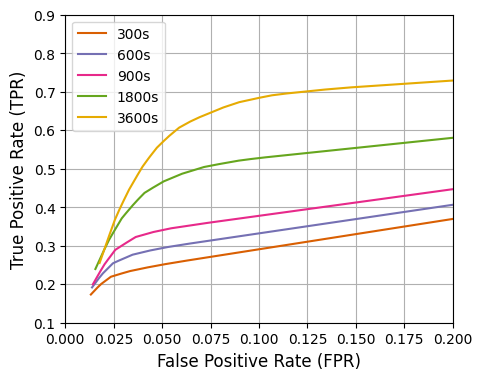

In [30]:


def calculate_roc_curve(trueList, falseList):
    thresholds = values = [i * (1/100) for i in range(101)] #np.linspace(0, 1, num=100)  # Schwellenwerte von 0 bis 1 in 100 Schritten
    tpr_values = []
    fpr_values = []
    tp = 0
    fn=0
    tn=0
    fp=0

    print("trueListLen: "+ str(len(trueList)))
    print("FalseListLen: "+ str(len(falseList)))

    for threshold in thresholds:
        for val in trueList:
            if(val >= threshold):
                tp=tp + 1
            else:
                fn=fn + 1
        for val in falseList:
            if(val >= threshold):
                fp = fp+1
            else:
                tn = tn+1
        
            
        # predicted_labels = falseList >= threshold         
        # tp = np.sum(np.logical_and(predicted_labels, trueList))
        # falseList = np.sum(np.logical_and(predicted_labels, np.logical_not(trueList)))
        # tn = np.sum(np.logical_and(np.logical_not(predicted_labels), np.logical_not(trueList)))
        # fn = np.sum(np.logical_and(np.logical_not(predicted_labels), trueList))
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        tpr_values.append(tpr)
        fpr_values.append(fpr)
        if(threshold == 0.1):
            print("tpr: "+str(tpr))
            print("fpr: "+str(fpr))

    return tpr_values, fpr_values


# Farbkarte auswählen (hier 'viridis' verwendet)
cmap = plt.cm.get_cmap('Dark2')
plt.figure(figsize=(5,4))

for i in range(len(observation_lengths)):
    if(observation_lengths[i]==180):
        continue
    # Beispielwerte
    true_labels = all_correlations_tp[i]
    predicted_scores = all_corrs_fp[i]


    # # Bestimme die minimale Länge der Arrays
    # min_length = min(len(true_labels), len(predicted_scores))

    # # Beschränke die Arrays auf die minimale Länge
    # true_labels = np.resize(true_labels, min_length)
    # predicted_scores = np.resize(predicted_scores, min_length)

    if(len(true_labels) == 0 or len(predicted_scores) == 0):
        continue

    # Berechne TPR und FPR für die ROC-Kurve
    tpr, fpr = calculate_roc_curve(true_labels, predicted_scores)

    # Plotte die ROC-Kurve
    plt.plot(fpr, tpr,color=cmap(i / len(observation_lengths)), label=str(observation_lengths[i])+"s")
    # plt.plot(x[i], y[i], marker='o', )
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('False Positive Rate (FPR)',fontsize=12)
plt.xlim(0.000,0.2)
plt.legend()
plt.grid(True)
plt.ylim(0.1,0.9)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
# plt.title('ROC Curve')
plt.savefig(r"C:\Users\Linus\git\cryptCorr\Bachelorarbeit\Batschi\Thesis\images\ROC_IMProxy_ObsLenComparison_ReferenzImpl_V2.png", dpi=300)
plt.show()
